In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

In [115]:
df=pd.read_csv("../data/base_camp.csv",na_values=['-999'])

In [116]:
Humidity = df.drop(['T_HMP', 'PRESS' ,'PRECIP'], axis=1)
Temp = df.drop(['RH', 'PRESS' ,'PRECIP'], axis=1)
Pressure = df.drop(['T_HMP', 'RH' ,'PRECIP'], axis=1)
Precipate = df.drop(['T_HMP', 'PRESS' ,'RH'], axis=1)

In [117]:
Humidity.head()

,TIMESTAMP,RH
0,10/17/19 14:00,99.578
1,10/17/19 15:00,92.273
2,10/17/19 16:00,86.358
3,10/17/19 17:00,88.629
4,10/17/19 18:00,74.045


In [118]:
print(Humidity.shape)
print(Temp.shape)
print(Pressure.shape)
print(Precipate.shape)

(24443, 2)
(24443, 2)
(24443, 2)
(24443, 2)


In [119]:
print("How many NaN are there in the humidity dataset?",Humidity.isna().sum())
print("How many NaN are there in the temperature dataset?",Temp.isna().sum())
print("How many NaN are there in the pressure dataset?",Pressure.isna().sum())

How many NaN are there in the humidity dataset? TIMESTAMP      0
RH           374
dtype: int64
How many NaN are there in the temperature dataset? TIMESTAMP      0
T_HMP        374
dtype: int64
How many NaN are there in the pressure dataset? TIMESTAMP      0
PRESS        374
dtype: int64


In [120]:
Tp = 7000

In [121]:
train_humidity =  np.array(Humidity.RH[:Tp])
#test_humidity =  np.array(Humidity.RH[Tp:])
train_temp =   np.array(Temp.T_HMP[:Tp])
#test_temp =   np.array(Temp.T_HMP[Tp:])
train_pressure =  np.array(Pressure.PRESS[:Tp])
#test_pressure =   np.array(Pressure.PRESS[Tp:])

In [122]:
 np.array(Pressure.PRESS[:Tp])

array([536.71, 537.15, 537.28, ..., 534.14, 534.56, 534.71])

In [123]:
Pressure.head()

,TIMESTAMP,PRESS
0,10/17/19 14:00,536.71
1,10/17/19 15:00,537.15
2,10/17/19 16:00,537.28
3,10/17/19 17:00,537.25
4,10/17/19 18:00,537.22


In [124]:
def plot_train_points(quantity='humidity',Tp=7000):
    plt.figure(figsize=(15,4))
    if quantity=='humidity':
        plt.title("Humidity of first {} data points".format(Tp),fontsize=16)
        plt.plot(train_humidity,c='k',lw=1)
    if quantity=='temperature':
        plt.title("Temperature of first {} data points".format(Tp),fontsize=16)
        plt.plot(train_temp,c='k',lw=1)
    if quantity=='pressure':
        plt.title("Pressure of first {} data points".format(Tp),fontsize=16)
        plt.plot(train_pressure,c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

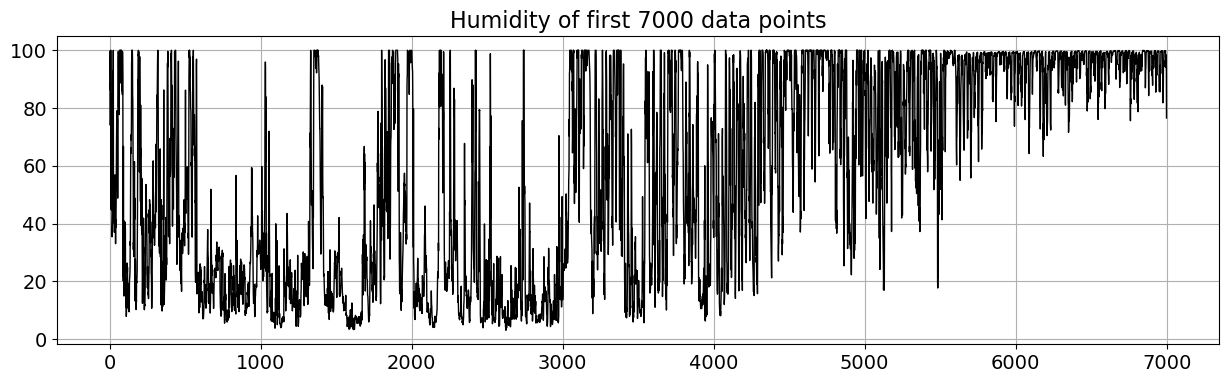

In [125]:
plot_train_points('humidity')

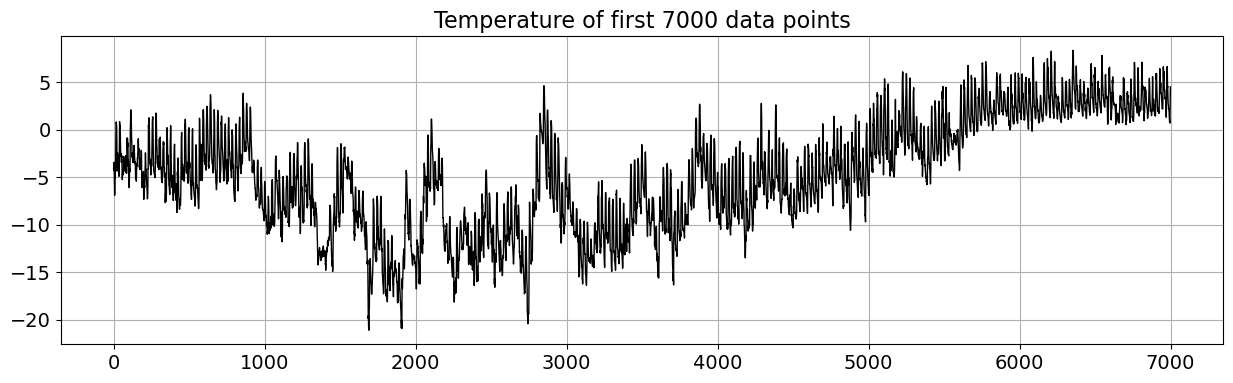

In [126]:
plot_train_points('temperature')

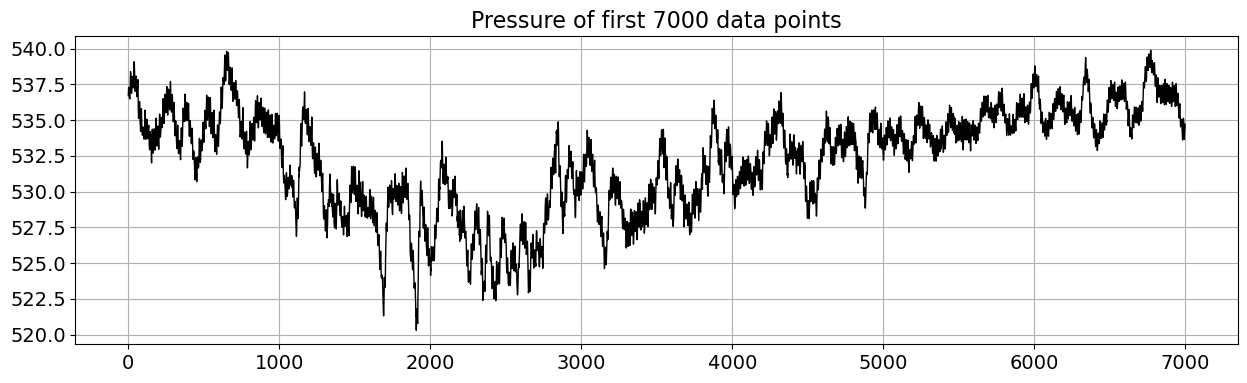

In [127]:
plot_train_points('pressure')

## Data interpolate and fill Nan values

In [128]:
Humidity.interpolate(inplace=True)
Humidity.dropna(inplace=True)

Temp.interpolate(inplace=True)
Temp.dropna(inplace=True)

Pressure.interpolate(inplace=True)
Pressure.dropna(inplace=True)

In [129]:
print(Humidity.shape)
print(Temp.shape)
print(Pressure.shape)

(24443, 2)
(24443, 2)
(24443, 2)


# RNN model for humidity

### Train and test splits on the tp = 7000

In [138]:
train_humidity =  np.array(Humidity.RH[:Tp])
test_humidity =  np.array(Humidity.RH[Tp:])

In [139]:
print("Train data length:", train_humidity.shape)
print("Test data length:", test_humidity.shape)

Train data length: (7000,)
Test data length: (17443,)


In [140]:
train_humidity=train_humidity.reshape(-1,1)
test_humidity=test_humidity.reshape(-1,1)

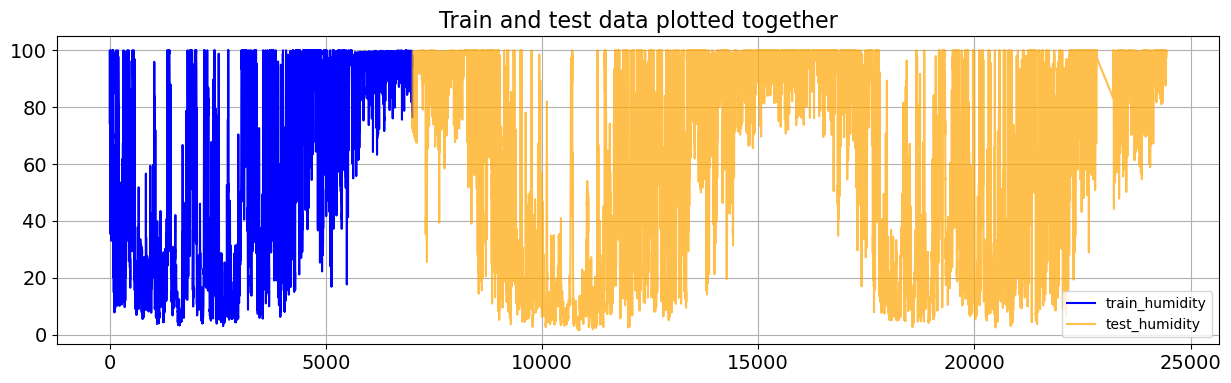

In [144]:
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together",fontsize=16)
plt.plot(np.arange(Tp),train_humidity,c='blue')
plt.plot(np.arange(Tp,24443),test_humidity,c='orange',alpha=0.7)
plt.legend(['train_humidity','test_humidity'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [145]:
step = 8